# Explore here

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers, models, Input
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense

2025-07-04 10:19:20.387011: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-04 10:19:20.390862: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-04 10:19:20.400120: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751624360.414503    7829 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751624360.418800    7829 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1751624360.432426    7829 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

In [2]:
train_dir = 'train_2'
test_dir = 'test_2'
img_size = 150
batch_size = 32
lr = 1e-4
epochs = 8

In [3]:
def normalization(img):
    img = img / 255.0 
    img = (img - [0.485, 0.456, 0.406]) / [0.229, 0.224, 0.225]
    return img

train_datagen = ImageDataGenerator(
    preprocessing_function=normalization,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(
    preprocessing_function=normalization
)

In [4]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True
)


test_generator = test_datagen.flow_from_directory(
    directory=os.path.dirname(test_dir),
    classes=[os.path.basename(test_dir)],
    target_size=(img_size, img_size),
    batch_size=1,
    class_mode='binary',
    shuffle=False
)

Found 1000 images belonging to 2 classes.
Found 500 images belonging to 1 classes.


In [5]:
def inverse_normalize(img):
    img = img * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]
    img = np.clip(img, 0, 1)
    return img

In [6]:
model = Sequential()
model.add(Conv2D(64, (3,3), activation='relu', padding='same', input_shape=(img_size, img_size, 3)))
model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
model.add(MaxPool2D((2,2)))

model.add(Conv2D(128, (3,3), activation='relu', padding='same'))
model.add(Conv2D(128, (3,3), activation='relu', padding='same'))
model.add(MaxPool2D((2,2)))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

/home/vscode/.local/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-07-04 10:19:24.558889: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
2025-07-04 10:19:24.644927: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 179437568 exceeds 10% of free system memory.
2025-07-04 10:19:25.038205: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 179437568 exceeds 10% of free system memory.
2025-07-04 10:19:25.115582: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 179437568 exceeds 10% of free system memory.


In [7]:
model.compile(
    optimizer=Adam(learning_rate=lr),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)


In [8]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

checkpoint = ModelCheckpoint(
    'modelo_mejor.keras',
    monitor='val_loss',
    save_best_only=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=2,
    min_lr=1e-7
)

In [9]:
# Fase 1: Entrenar solo las nuevas capas
print("\n--- FASE 1: Entrenamiento de capas nuevas ---")
history = model.fit(
    train_generator,
    epochs=3,
    callbacks=[early_stop, checkpoint, reduce_lr]
)


--- FASE 1: Entrenamiento de capas nuevas ---


/home/vscode/.local/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/3


2025-07-04 10:19:26.957795: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 179437568 exceeds 10% of free system memory.
2025-07-04 10:19:27.997765: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 184320000 exceeds 10% of free system memory.


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.5156 - loss: 0.7313 - precision: 0.4874 - recall: 0.3426

/home/vscode/.local/lib/python3.11/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss,precision,recall
  current = self.get_monitor_value(logs)
/home/vscode/.local/lib/python3.11/site-packages/keras/src/callbacks/model_checkpoint.py:302: UserWarning: Can save best model only with val_loss available.
  if self._should_save_model(epoch, batch, logs, filepath):


32/32 ━━━━━━━━━━━━━━━━━━━━ 197s 6s/step - accuracy: 0.5157 - loss: 0.7307 - precision: 0.4885 - recall: 0.3444 - learning_rate: 1.0000e-04
Epoch 2/3


/home/vscode/.local/lib/python3.11/site-packages/keras/src/callbacks/callback_list.py:145: UserWarning: Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss,precision,recall,learning_rate.
  callback.on_epoch_end(epoch, logs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 200s 6s/step - accuracy: 0.5058 - loss: 0.6881 - precision: 0.5038 - recall: 0.9867 - learning_rate: 1.0000e-04
Epoch 3/3
32/32 ━━━━━━━━━━━━━━━━━━━━ 199s 6s/step - accuracy: 0.6366 - loss: 0.6414 - precision: 0.6578 - recall: 0.5995 - learning_rate: 1.0000e-04


In [10]:
val_loss, val_acc, val_prec, val_rec = model.evaluate(test_generator)
print(f"\nRendimiento final en validación:")
print(f"Accuracy: {val_acc:.2%}")
print(f"Precisión: {val_prec:.2%}")
print(f"Recall: {val_rec:.2%}")

500/500 ━━━━━━━━━━━━━━━━━━━━ 39s 77ms/step - accuracy: 0.8243 - loss: 0.5811 - precision: 0.0000e+00 - recall: 0.0000e+00

Rendimiento final en validación:
Accuracy: 72.00%
Precisión: 0.00%
Recall: 0.00%


In [11]:
predicciones = model.predict(test_generator, verbose=1)
clases_predichas = (predicciones > 0.5).astype(int).flatten()

500/500 ━━━━━━━━━━━━━━━━━━━━ 38s 75ms/step


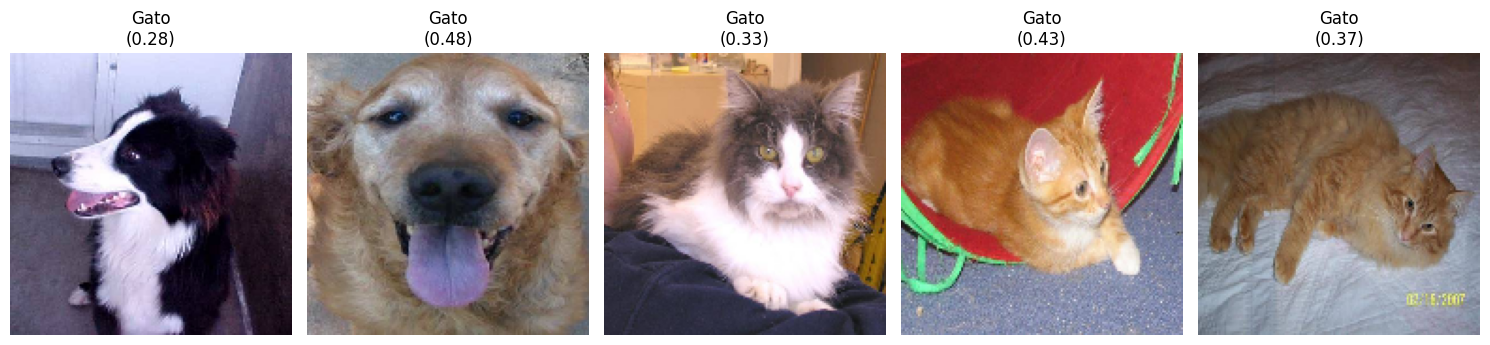

In [12]:
# Visualización de resultados
nombres_archivos = test_generator.filenames
plt.figure(figsize=(15, 5))
for i in range(5):
    idx = np.random.randint(len(nombres_archivos))
    ruta_img = os.path.join(test_dir, nombres_archivos[idx].replace('test_2/', ''))    
    img = tf.keras.preprocessing.image.load_img(ruta_img, target_size=(img_size, img_size))
    plt.subplot(1, 5, i + 1)
    plt.imshow(img)
    etiqueta = "Perro" if clases_predichas[idx] == 1 else "Gato"
    plt.title(f"{etiqueta}\n({predicciones[idx][0]:.2f})")
    plt.axis('off')
plt.tight_layout()
plt.show()

In [13]:
print(predicciones[:5])

[[0.2486175 ]
 [0.45578787]
 [0.49275497]
 [0.28714737]
 [0.31077012]]


In [ ]:
#model.save("Mejor.h5")